In this notebook, we perform some techinque of fine-tuning a pre-trained model. We use `peft`, the library dedicated these tasks developed by [Hugging Face](https://huggingface.co/docs/peft/en/index). We focused on fine-tuning the pre-trained model BLOOM 560M. LoRA, Prefix trained and Language-adaptive fine-tuning are technique we focused on in this notebook.

## 0. Installations, Imports and Helper Functions

In [ ]:
## Install and import anything required. Capture hides the output from the cell.
# @title Install and import required packages. (Run Cell)

!pip install livelossplot
!pip install colorama  # print colors :).

#!pip install transformers datasets
#!pip install seaborn umap-learn
#!pip install livelossplot
!pip install datasets
#!pip install -q transformers[torch]
#!pip install accelerate -U
!pip install peft

# Python utils
#!pip install -q ipdb      # debugging.
#!pip install -q colorama  # print colors :).

import os
import math
import urllib.request

# https://stackoverflow.com/questions/68340858/in-google-colab-is-there-a-programing-way-to-check-which-runtime-like-gpu-or-tpu
if os.environ["COLAB_GPU"] and int(os.environ["COLAB_GPU"]) > 0:
    print("a GPU is connected.")
else:
    print("Only CPU accelerator is connected.")

# # https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html#gpu-memory-allocation
# # Avoid GPU memory allocation to be done by JAX.
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"

# note that jax might not run on a GPU here in colab, however we are not actually training jax models in this notebook
# import chex
# import flax
# import flax.linen as nn
# import jax
# import jax.numpy as jnp
# from jax import grad, jit, vmap
# import optax

import transformers
from transformers import pipeline, AutoTokenizer, AutoModel
import datasets
import peft

# from PIL import Image
# from livelossplot import PlotLosses

# Utils.
import colorama

import torch
#import torchvision

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import itertools
import random

# download images used in notebook
# urllib.request.urlretrieve(
#     "https://images.unsplash.com/photo-1529778873920-4da4926a72c2?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8Y3V0ZSUyMGNhdHxlbnwwfHwwfHw%3D&w=1000&q=80",
#     "cat.png",
# )

import copy

# import gensim
# from nltk.data import find
# import nltk

# nltk.download("word2vec_sample")

import huggingface_hub
# import ipywidgets as widgets
# from IPython.display import display

In [ ]:
from tqdm import tqdm
!pip install evaluate
!pip install sacrebleu
import evaluate
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
from peft import get_peft_config, get_peft_model, get_peft_model_state_dict, PrefixTuningConfig, TaskType

In [ ]:
#@title Helpher functions
max_num_tokens = 256
def merge_columns(example):
  example["text"] = example["inputs"] + " ->: " + example["targets"]
  return example

def tokenize(prompt):
  result = tokenizer(
      prompt,
      truncation=True,
      max_length=max_num_tokens,
      padding="max_length",
  )
  return {
      "input_ids": result["input_ids"],
      "attention_mask": result["attention_mask"],
  }

# seed = 2
# temperature = 1.0
# top_p = 0.9

def eval_model_pred(model, eval_dataset):
  #prediction = []
  chrfpp = evaluate.load("chrf")
  eval_chrfpp = 0
  bert = evaluate.load("bertscore")
  eval_rouge = 0
  for i in tqdm(range(eval_dataset.num_rows)):
    #Prediction with the model
    response = run_sample(
        model,
        tokenizer,
        prompt=eval_dataset["inputs"][i] + " ->:",
        seed= 2,
        temperature=1.0,
        top_p=0.9,
    )
    #prediction.append(response)
    #
    e = chrfpp.compute(predictions=[response], references=[eval_dataset['targets'][i]], lowercase=True)
    eval_chrfpp += e["score"]
    # eval_bert += bert.compute([response], [eval_dataset['targets'][i]])
  #eval_chrhpp = chrfpp.compute(predictions=prediction, references=eval_dataset["inputs"])
  #eval_rouge = rouge.compute(predictions=prediction, references=eval_dataset['inputs'], model_type=model_name)
  return eval_chrfpp/eval_dataset.num_rows#, eval_rouge#/eval_dataset.num_rows

def print_sample(prompt: str, sample: str):
  print(colorama.Fore.MAGENTA + prompt, end="")
  print(colorama.Fore.BLUE + sample)
  print(colorama.Fore.RESET)


def run_sample(
    model,
    tokenizer,
    prompt: str,
    seed: int| None = None,
    temperature: float = 0.6,
    top_p: float = 0.9,
    max_new_tokens: int = 64
) -> str:
  #tokenize and return pytorch tensor
  inputs = tokenizer(prompt, return_tensors = "pt")
  #tensor containing token of id of the inputs
  input_ids = inputs['input_ids']
  #tensor of O and 1 specifying which token to ignore
  attention_mask = inputs['attention_mask']
  input_ids = input_ids.to(model.device)#move inputs_ids to the device where model is located like CPU, GPU
  attention_mask = attention_mask.to(model.device)

  generation_config = transformers.GenerationConfig(
      do_sample = True,
      temperature = temperature,
      top_p = top_p,
      pad_token_id = tokenizer.pad_token_id,
      top_k = 0,
  )

  if seed is not None:
      torch.manual_seed(seed)

  generation_output = model.generate(
      input_ids = input_ids,
      attention_mask = attention_mask,
      return_dict_in_generate = True,
      output_scores = True,
      max_new_tokens = max_new_tokens,
      generation_config = generation_config
  )

  #we assume a single sample is returned to make things simpler
  assert len(generation_output.sequences) == 1
  output_sequence = generation_output.sequences[0]
  output_string = tokenizer.decode(output_sequence)
  response = output_string.split(prompt)[1].rstrip()
  #print_sample(prompt, response)
  return response

# 1. Load pretrained model BLOOM 560M

The pre-trained model used here is [BLOOM 560M](https://huggingface.co/bigscience/bloom-560m). BLOOM has more than 560 million parameters to train. It requirestoo much storage space and computational ressources to learn all those parameters. One way to adress these issues, named fine-tuning, consists in training this model in a small number of parameters of this model. And Parameter-Efficient Fine-Tuning (PEFT) provides tools to do it.

In [ ]:
#Define the model name
model_name ="bigscience/bloom-560m"
#Define the tokenizer for this model
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
#Define the pretrained model BLOOM-560m
model = transformers.AutoModelForCausalLM.from_pretrained(model_name)
#checks if CUDA is available
if torch.cuda.is_available():
  model = model.to("cuda")
  print("cuda is available")
#Set the padding and end-to-sequence(EOS) token to have the same id,
tokenizer.pad_token_id = tokenizer.eos_token_id

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


cuda is available


In [ ]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 2. Dataset

We use some dataset to reach our goal. The most of this implementation is done using [Aya dataset](https://huggingface.co/datasets/CohereForAI/aya_dataset)  and [dolly-machine-translated](https://huggingface.co/datasets/CohereForAI/aya_evaluation_suite). The first serves to training and the second to evaluation.

## Loading and preprocessing

We use 600 examples from Aya dataset to train the model and 100 examples from dolly-machine-translated dataset.

For the training set, we merge the `inputs` and the `targets` of each example then generate `text`. Then we conserve this key and remove all remaining. When putting together `inputs` and the `targets`, the column of `text` in the training set may content a very large number of words and each of the example can get different size. To make reduce computation time, we truncate each `text` to $256$ words and tokenize. This can lead to an issue : where `text` contains $256$ words from `inputs`. We adress this problem by choosing the training set such as example has the number of words in `ìnputs` column of each example is less than $256/2 = 128$.

In [ ]:
#training data
train_dataset = datasets.load_dataset("CohereForAI/aya_dataset")
train_dataset = train_dataset["train"].filter(lambda example: example["language_code"] in ["sna"])
#Drop inputs with more than max_num_tokens//2 tokens
train_dataset = train_dataset.filter(lambda x: len(x["inputs"].split()) < max_num_tokens//2)
#Decrease the data size due to running time
if train_dataset.num_rows > 600:
  train_dataset = train_dataset.filter(lambda example, idx: idx < 600, with_indices=True)
#Merge inputs and targets
train_dataset = train_dataset.map(merge_columns)
train_dataset = train_dataset.map(lambda x: tokenize(x["text"]), batched=True,
                                  remove_columns=train_dataset.column_names)
print(train_dataset)

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 600
})


In [ ]:
#evaluation data
#For most of use we didn't need to tokenize the dataset
eval_dataset = datasets.load_dataset("CohereForAI/aya_evaluation_suite", 'dolly_machine_translated')
eval_dataset = eval_dataset["test"].filter(lambda example: example["language"] in ["sna"])
# eval_dataset = eval_dataset.filter(lambda x: len(x["inputs"].split()) < max_num_tokens//2)
if eval_dataset.num_rows> 100:
  eval_dataset = eval_dataset.filter(lambda example, idx: idx < 100, with_indices=True)
# eval_dataset = eval_dataset.map(merge_columns)
# eval_dataset = eval_dataset.map(lambda x: tokenize(x["text"]), batched=True)
print(eval_dataset)

Dataset({
    features: ['id', 'inputs', 'targets', 'language', 'script', 'source_id'],
    num_rows: 100
})


In [ ]:
#Tokenized eval_dataset:
#To evaluate the model using trainer.evaluate(eval_dataset) we need
#to tokenize the dataset
eval_dataset = eval_dataset.map(merge_columns)
eval_dataset_token = eval_dataset.map(lambda x: tokenize(x["text"]), batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

# 3. Fine-tune the LLM BLOOM

BLOOM 560M is a pre-trained model developped by Hugging Face (available here https://huggingface.co/bigscience/bloom-560m). It has more than 560 millions parameters. Here, we will use this model for downstream task. For this, we will trained just a small number of its parameters. For this purpose, we perfom some fine-tune techniques. We use the Parameter-Efficient Fine-Tuning (PEFT) library to fine-tune the model. The idea consists in training a small set of its parameters. The methods we used are : LoRA (Low-Rank Adaptive), Prefix-Tuning and Language-Adaptive Fine-Tuning.

## 3.1. LoRA

LoRA is a PEFT method that decomposes a large matrix into two smaller low-rank matrices in the attention layers.

In [ ]:
#@title Hyperparameters
#
MICRO_BATCH_SIZE =4
BATCH_SIZE = 16
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE//MICRO_BATCH_SIZE
EPOCHS = 30
#
LEARNING_RATE = 4e-3
CUTOFF_LEN = max_num_tokens
LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.05
WARMUP_STEPS = 15
# QUERY_USED_DURING_TRAINING = "Ọkunrin naa la gbọ"

In [ ]:
#@title Setting LoRA parameters
#Set the configuration parameters for to create a LoRA model
#from the pretrained model
peft_config = peft.LoraConfig(
    task_type=peft.TaskType.CAUSAL_LM,
    inference_mode=False,
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=None,
)
peft_model = peft.get_peft_model(copy.deepcopy(model), peft_config)
peft_model.print_trainable_parameters()

if torch.cuda.is_available():
  peft_model = peft_model.to("cuda")
  print("cuda is available")

trainable params: 1,572,864 || all params: 560,787,456 || trainable%: 0.2804741766549072
cuda is available


In [ ]:
#@title LoRA training
training_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    fp16=True,
    logging_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=WARMUP_STEPS,
    # lr_scheduler_type="cosine",
    output_dir="tmp",
    save_strategy="no",
    logging_dir="./logs",
    #evaluation_strategy="epoch",
    logging_strategy="epoch",
)
##
trainer = transformers.Trainer(
    model=peft_model,
    train_dataset=train_dataset,
    # Unused. But needed to run hacky inference.
    eval_dataset=[{'input_ids': [], 'attention_mask': []}],
    args=training_arguments,
    #callbacks=[PlotLossCalback],
    #Form a list of batch from train_dataset or eval_dataset
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    tokenizer=tokenizer,
)
peft_model.config.use_cache = False#Hide warning
trainer.train(resume_from_checkpoint=False)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Step,Training Loss
37,5.522400
75,4.387000
112,4.113400
150,3.741600
187,3.581300
225,3.330300
262,3.286400
300,3.031900
337,2.913900
375,2.701700


TrainOutput(global_step=1110, training_loss=2.039373410714639, metrics={'train_runtime': 1397.4588, 'train_samples_per_second': 12.881, 'train_steps_per_second': 0.794, 'total_flos': 8289824758824960.0, 'train_loss': 2.039373410714639, 'epoch': 29.6})

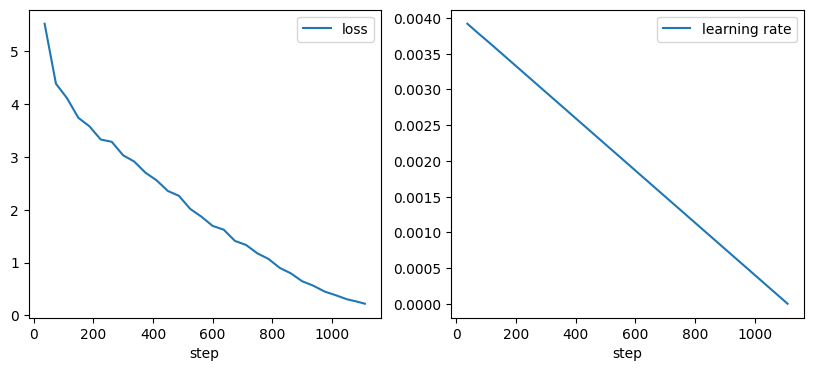

In [ ]:
train_loss_history1 = trainer.state.log_history
train_loss = []
train_step = []
train_lr = []

for i in range(len(train_loss_history1)-1):
  train_loss.append(train_loss_history1[i]['loss'])
  train_step.append(train_loss_history1[i]["step"])
  train_lr.append(train_loss_history1[i]["learning_rate"])

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(train_step, train_loss, label="loss")
ax[0].set_xlabel("step")
ax[0].legend()

ax[1].plot(train_step, train_lr, label="learning rate")
ax[1].set_xlabel("step")
ax[1].legend()

### Evaluation

In [ ]:
# response = run_sample(
#         model,
#         tokenizer,
#         prompt=eval_dataset["inputs"][5] + " ->: ",
#         seed=seed,
#         temperature=temperature,
#         top_p=top_p,
#     )
# print(response)

In [ ]:
chrfpp1= eval_model_pred(peft_model, eval_dataset)

100%|██████████| 100/100 [03:09<00:00,  1.90s/it]


In [ ]:
print("Score chrF++ for LoRA: ",chrfpp1)

Score chrF++ for LoRA:  16.774141755560986


In [ ]:
trainer.evaluate(eval_dataset_token)

{'eval_loss': 6.51148796081543,
 'eval_runtime': 3.499,
 'eval_samples_per_second': 28.58,
 'eval_steps_per_second': 3.715,
 'epoch': 29.76}

## 3.2 Prefix tuning

Prefix tuning is another PEFT method that prefixes a series of task-specific vectors to the input sequence that can be learned while the pre-trained model frozen. https://huggingface.co/docs/peft/main/en/task_guides/seq2seq-prefix-tuning#prefix-tuning-for-conditional-generation

In [ ]:

#@title Hyperparameters
#
# max_num_tokens = 216
MICRO_BATCH_SIZE =4
BATCH_SIZE = 16
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE//MICRO_BATCH_SIZE
EPOCHS = 30
#
LEARNING_RATE = 8e-3
CUTOFF_LEN = max_num_tokens
WARMUP_STEPS = 15

In [ ]:
#@title Setting Prefix-tuning parameters
peft_config = PrefixTuningConfig(
    task_type = peft.TaskType.CAUSAL_LM,
    inference_mode = False,
    num_virtual_tokens=20,
)
# tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
prefix_model = transformers.AutoModelForCausalLM.from_pretrained(model_name)
prefix_model = get_peft_model(copy.deepcopy(prefix_model), peft_config)
prefix_model.print_trainable_parameters()

if torch.cuda.is_available():
  prefix_model = prefix_model.to("cuda")
  print("cuda is available")

trainable params: 983,040 || all params: 560,197,632 || trainable%: 0.1754809274167014
cuda is available


In [ ]:
#@title Training
training_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    fp16=True,
    logging_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=WARMUP_STEPS,
    # lr_scheduler_type="cosine",
    output_dir="tmp2",
    save_strategy="no",
    #evaluation_strategy="epoch",
    logging_strategy="epoch",
)
##
prefix_trainer = transformers.Trainer(
    model=prefix_model,
    train_dataset=train_dataset,
    args=training_arguments,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    tokenizer=tokenizer,
)
prefix_model.config.use_cache = False
prefix_trainer.train(resume_from_checkpoint=False)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
You're using a BloomTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
37,8.792100
75,6.020100
112,5.727200
150,5.320900
187,5.229700
225,4.893500
262,4.895500
300,4.631000
337,4.614900
375,4.420200


TrainOutput(global_step=1110, training_loss=4.416494682243278, metrics={'train_runtime': 1367.5771, 'train_samples_per_second': 13.162, 'train_steps_per_second': 0.812, 'total_flos': 8246918035537920.0, 'train_loss': 4.416494682243278, 'epoch': 29.6})

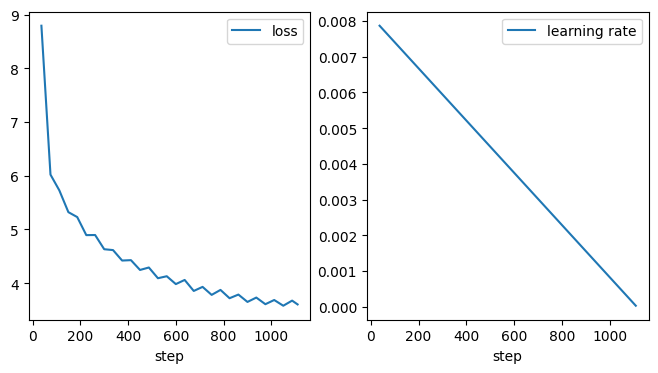

In [ ]:
train_loss_history2 = prefix_trainer.state.log_history
train_loss = []
train_step = []
train_lr = []

for i in range(len(train_loss_history2)-1):
  train_loss.append(train_loss_history2[i]['loss'])
  train_step.append(train_loss_history2[i]["step"])
  train_lr.append(train_loss_history2[i]["learning_rate"])

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(train_step, train_loss, label="loss")
ax[0].set_xlabel("step")
ax[0].legend()

ax[1].plot(train_step, train_lr, label="learning rate")
ax[1].set_xlabel("step")
ax[1].legend()

### Evaluation

In [ ]:
chrfpp2 = eval_model_pred(prefix_model, eval_dataset)

100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


In [ ]:
print("Score chrF++ for Prefix-Tuning : ", chrfpp2)

Score chrF++ for Prefix-Tuning :  14.368701058841644


In [ ]:
prefix_trainer.evaluate(eval_dataset_token)

{'eval_loss': 5.076147079467773,
 'eval_runtime': 3.4617,
 'eval_samples_per_second': 28.887,
 'eval_steps_per_second': 3.755,
 'epoch': 29.6}

## 3.3 Language-adaptive fine-tuning

Another way to fine-tuning consists in, first, fine-tuning the pre-trained model on a general corpus in the target language and, second,  fine-tune this model to accomplish the downstream task.  Here we used the mC4 dataset (available here: https://huggingface.co/datasets/mc4).

Here, first we fine-tune BLOOM with on this dataset and second, we fine-tune the resulting model using prefix-tuning.

### 3.3.1 First fine-tuning with LoRA

In [ ]:
#@title Training data
from datasets import load_dataset
zu_mc4 = load_dataset("mc4", "sn")
train_zu_mc4 = zu_mc4['train'].filter(lambda x: len(x["text"].split()) < max_num_tokens//2)
if train_zu_mc4.num_rows>1500:
  train_zu_mc4 = train_zu_mc4.shuffle().filter(lambda example, idx: idx <1500, with_indices=True)
train_zu_mc4 = train_zu_mc4.map(lambda x: tokenize(x["text"]),
                                remove_columns=train_zu_mc4.column_names)
eval_zu_mc4 = zu_mc4["validation"].filter(lambda x: len(x["text"].split()) < max_num_tokens//2)
if eval_zu_mc4.num_rows>100:
  eval_zu_mc4 = eval_zu_mc4.shuffle().filter(lambda example, idx: idx <100, with_indices=True)

eval_zu_mc4 = eval_zu_mc4.map(lambda x: tokenize(x["text"]),
                                remove_columns=eval_zu_mc4.column_names)
del zu_mc4

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/326392 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200541 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/306 [00:00<?, ? examples/s]

Filter:   0%|          | 0/197 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
print(train_zu_mc4)
print(eval_zu_mc4)

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 1500
})
Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 100
})


In [ ]:
#@title Hyperparameters
#
MICRO_BATCH_SIZE =4
BATCH_SIZE = 16
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE//MICRO_BATCH_SIZE
EPOCHS = 30
LEARNING_RATE = 4e-3
CUTOFF_LEN = max_num_tokens
LORA_R = 8
LORA_ALPHA = 32
LORA_DROPOUT = 0.05
WARMUP_STEPS = 15
# QUERY_USED_DURING_TRAINING = "Ọkunrin naa la gbọ"

In [ ]:
#@title Setting LoRA parameters
#Set the configuration parameters for to create a LoRA model
#from the pretrained model
peft_config = peft.LoraConfig(
    task_type=peft.TaskType.CAUSAL_LM,
    inference_mode=False,
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=None,
)
adapt_model = peft.get_peft_model(model, peft_config)
adapt_model.print_trainable_parameters()

if torch.cuda.is_available():
  adapt_model = adapt_model.to("cuda")
  print("cuda is available")

trainable params: 786,432 || all params: 560,001,024 || trainable%: 0.14043402892063284
cuda is available


In [ ]:
#@title LoRA training
training_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    fp16=True,
    logging_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=WARMUP_STEPS,
    output_dir="tmp",
    save_strategy="no",
    logging_dir="./logs",
    #evaluation_strategy="epoch",
    logging_strategy="epoch",
)
##
trainer = transformers.Trainer(
    model=adapt_model,
    train_dataset=train_zu_mc4,
    # Unused. But needed to run hacky inference.
    eval_dataset=[{'input_ids': [], 'attention_mask': []}],
    args=training_arguments,
    #callbacks=[PlotLossCalback],
    #Form a list of batch from train_zu_mc4 or eval_dataset
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    tokenizer=tokenizer,
)
adapt_model.config.use_cache = False#Hide warning
trainer.train(resume_from_checkpoint=False)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Step,Training Loss
93,4.325100
187,4.358900
281,4.187800
375,4.154700
468,4.113400
562,3.980300
656,3.957800
750,3.888600
843,3.850400
937,3.738600


TrainOutput(global_step=2790, training_loss=3.2887210859620017, metrics={'train_runtime': 3452.8523, 'train_samples_per_second': 13.033, 'train_steps_per_second': 0.808, 'total_flos': 2.078266324156416e+16, 'train_loss': 3.2887210859620017, 'epoch': 29.76})

### 3.3.2. Second fine-tuning : Prefix-tuning

In [ ]:
#@title Hyperparameters
#
# max_num_tokens = 216
MICRO_BATCH_SIZE =4
BATCH_SIZE = 16
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE//MICRO_BATCH_SIZE
EPOCHS = 30
#
LEARNING_RATE = 8e-3
WARMUP_STEPS = 15

In [ ]:
#@title Setting Prefix-tuning parameters
peft_config = PrefixTuningConfig(
    task_type = peft.TaskType.CAUSAL_LM,
    inference_mode = False,
    num_virtual_tokens=30,
)
adapt_prefix_model = get_peft_model(adapt_model, peft_config)
adapt_prefix_model.print_trainable_parameters()

if torch.cuda.is_available():
  adapt_prefix_model = adapt_prefix_model.to("cuda")
  print("cuda is available")

trainable params: 1,474,560 || all params: 561,475,584 || trainable%: 0.26262228350075506
cuda is available


In [ ]:
#@title Training
training_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    fp16=True,
    logging_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=WARMUP_STEPS,
    output_dir="tmp3",
    save_strategy="no",
    logging_strategy="epoch",
)
##
adapt_trainer2 = transformers.Trainer(
    model=adapt_prefix_model,
    train_dataset=train_dataset,
    args=training_arguments,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    tokenizer=tokenizer,
)
adapt_prefix_model.config.use_cache = False
adapt_trainer2.train(resume_from_checkpoint=False)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Step,Training Loss
37,9.983800
75,6.287900
112,5.895600
150,5.467300
187,5.390900
225,5.056700
262,5.070500
300,4.815700
337,4.807900
375,4.610800


TrainOutput(global_step=1110, training_loss=4.674821664621164, metrics={'train_runtime': 1460.8674, 'train_samples_per_second': 12.321, 'train_steps_per_second': 0.76, 'total_flos': 8268371397181440.0, 'train_loss': 4.674821664621164, 'epoch': 29.6})

In [ ]:
# for hist in train_loss_history3:
#   if not hist.get('loss', 0):
#     continue
#   print(hist['loss'])

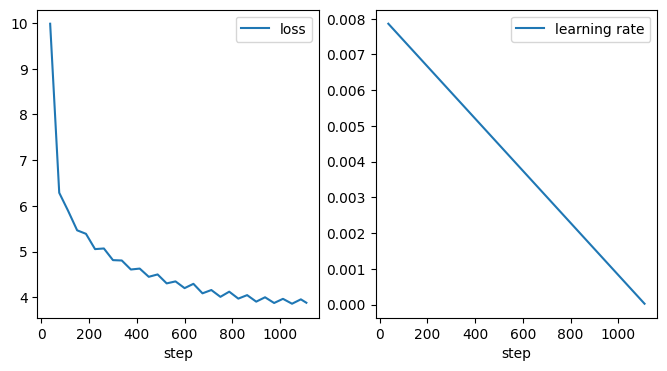

In [ ]:
#Plot
train_loss_history3 = adapt_trainer2.state.log_history
train_loss = []
train_step = []
train_lr = []

for i in range(len(train_loss_history3)-1):
  train_loss.append(train_loss_history3[i]['loss'])
  train_step.append(train_loss_history3[i]["step"])
  train_lr.append(train_loss_history3[i]["learning_rate"])

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(train_step, train_loss, label="loss")
ax[0].set_xlabel("step")
ax[0].legend()

ax[1].plot(train_step, train_lr, label="learning rate")
ax[1].set_xlabel("step")
ax[1].legend()

In [ ]:
#@title Evaluation
chrfpp3 = eval_model_pred(adapt_prefix_model, eval_dataset)

100%|██████████| 100/100 [03:13<00:00,  1.94s/it]


In [ ]:
print("Score chrf++ Language-Adaptive : ", chrfpp3)

Score chrf++ Language-Adaptive :  14.519033174510364


In [ ]:
adapt_trainer2.evaluate(eval_dataset_token)

{'eval_loss': 5.1270222663879395,
 'eval_runtime': 3.6126,
 'eval_samples_per_second': 27.681,
 'eval_steps_per_second': 3.598,
 'epoch': 29.6}